In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [3]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')

### CNN training

In [4]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 32)            0         
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 64)                45120     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

### LSTM training

In [5]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
23003/23

### AE-LSTM

In [6]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 46, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65    

Let's save our models

In [7]:
CNN_model.save("../../models/cnn_ciciot_updated_model.keras")

In [8]:
LSTM_model.save("../../models/lstm_ciciot_updated_model.keras")

In [9]:
AE_LSTM_model.save("../../models/ae-lstm_ciciot_updated_model.keras")

In [10]:
import pickle

In [11]:
file_name_cnn = '../../models/cnn_updated_CICIOT2023.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_updated_CICIOT2023.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_updated_CICIOT2023.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

['../../models/ae-lstm_updated_CICIOT2023.pkl']

### CNN metrics

19717/19717 [==============================] - 12s 594us/step
              precision    recall  f1-score   support

      Normal       0.83      0.92      0.87     34081
     Attacks       1.00      0.99      0.99    596849

    accuracy                           0.98    630930
   macro avg       0.91      0.95      0.93    630930
weighted avg       0.99      0.98      0.99    630930

Test Loss: 0.0335
Test Accuracy: 0.9850


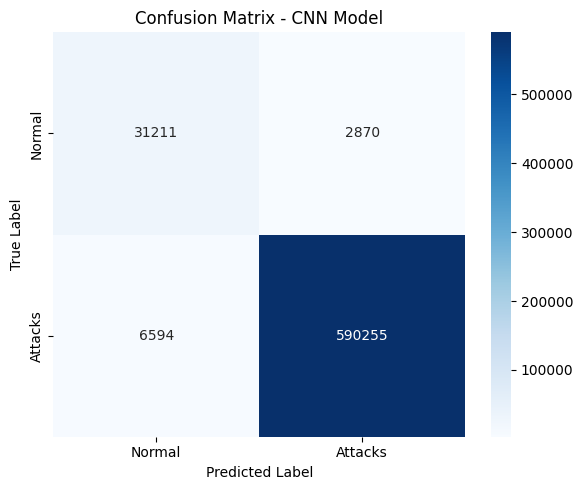

Attacks detected (True Positive) : 590255
Normal traffic detected (True Negative) : 31211
Attacks missed (False Negative) : 6594
False alarms (False Positive) : 2870


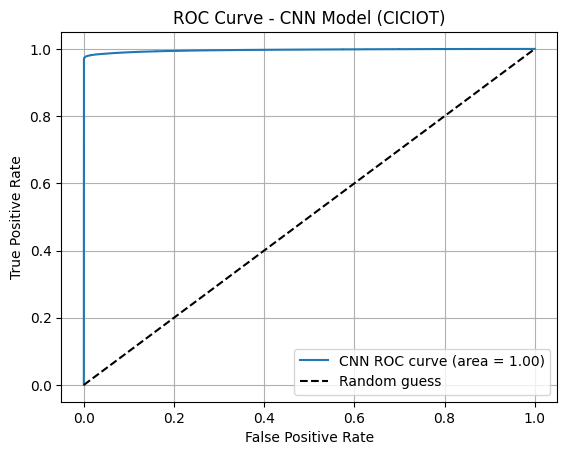

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### LSTM metrics

19717/19717 [==============================] - 69s 3ms/step
              precision    recall  f1-score   support

      Normal       0.84      0.89      0.86     34081
     Attacks       0.99      0.99      0.99    596849

    accuracy                           0.98    630930
   macro avg       0.92      0.94      0.93    630930
weighted avg       0.99      0.98      0.99    630930

Test Loss: 0.0335
Test Accuracy: 0.9850


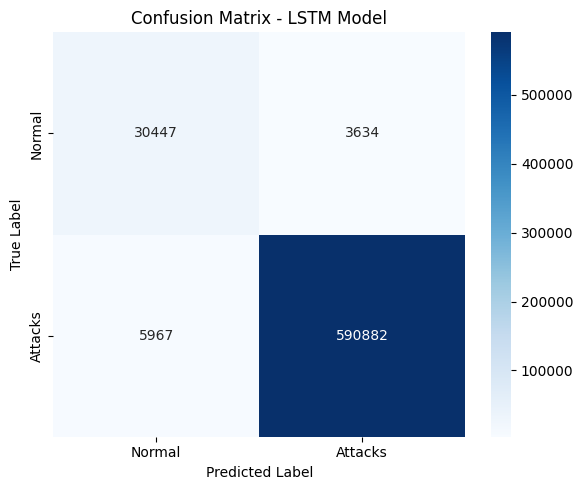

Attacks detected (True Positive) : 590882
Normal traffic detected (True Negative) : 30447
Attacks missed (False Negative) : 5967
False alarms (False Positive) : 3634


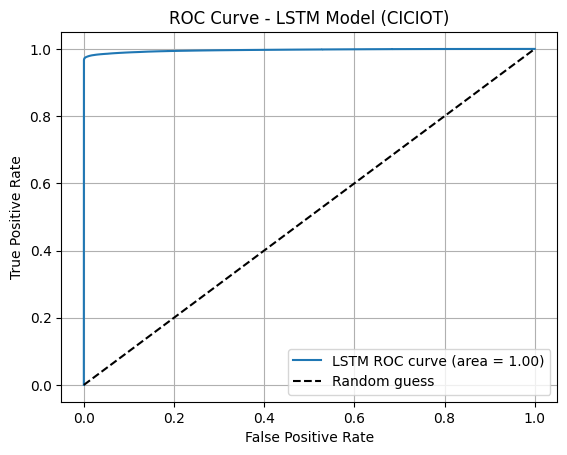

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### AE-LSTM metrics

19717/19717 [==============================] - 68s 3ms/step
              precision    recall  f1-score   support

      Normal       0.86      0.87      0.87     34081
     Attacks       0.99      0.99      0.99    596849

    accuracy                           0.99    630930
   macro avg       0.93      0.93      0.93    630930
weighted avg       0.99      0.99      0.99    630930

Test Loss: 0.0335
Test Accuracy: 0.9850


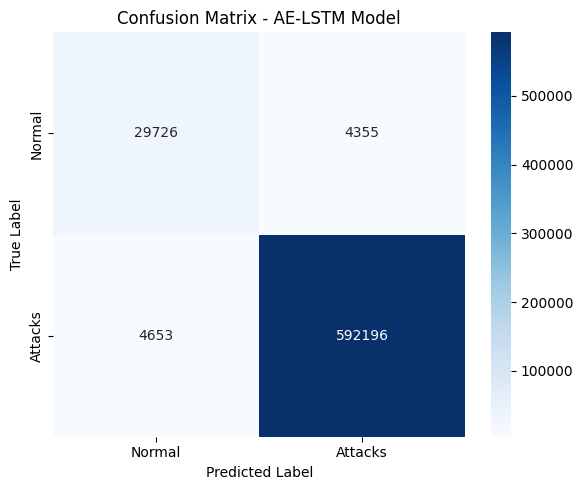

Attacks detected (True Positive) : 592196
Normal traffic detected (True Negative) : 29726
Attacks missed (False Negative) : 4653
False alarms (False Positive) : 4355


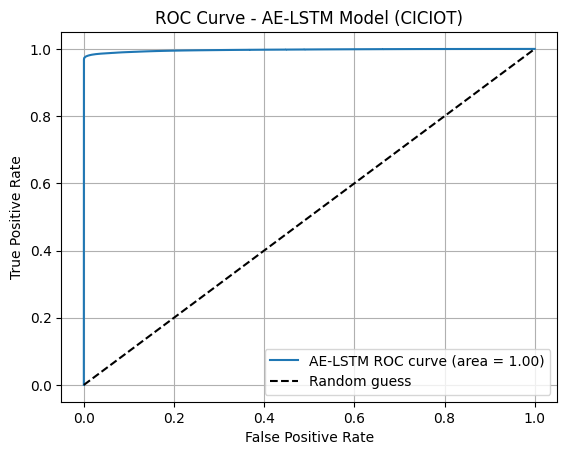

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()